### Loading data

In [ ]:
from neural_network import *
from torch.utils.data import DataLoader
from utils import *

ctx_train_dir = "./ctx/cropped"
crism_train_dir = "./normalized_evc"
ctx_test_dir = "./ctx/cropped/test"
crism_test_dir = "./normalized_evc/test"
ctx_val_dir = "./ctx/cropped/val"
crism_val_dir = "./normalized_evc/val"
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

batch_size = 16
patch_size = 256
num_epochs = 360
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ctx, train_crism = get_files_from_dir(ctx_train_dir, ".cub"), get_files_from_dir(crism_train_dir, ".img")
test_ctx, test_crism = get_files_from_dir(ctx_test_dir, ".cub"), get_files_from_dir(crism_test_dir, ".img")
val_ctx, val_crism = get_files_from_dir(ctx_val_dir, ".cub"), get_files_from_dir(crism_val_dir, ".img")

train_dataset = CTXCRISMDataset(train_ctx, train_crism, transform=get_train_augmentations(patch_size))
val_dataset = CTXCRISMDataset(val_ctx, val_crism, transform=get_val_augmentations(patch_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

d:\Software\Python\anaconda\envs\nn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS

### Visualize augmentations (doesn't work temporary)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

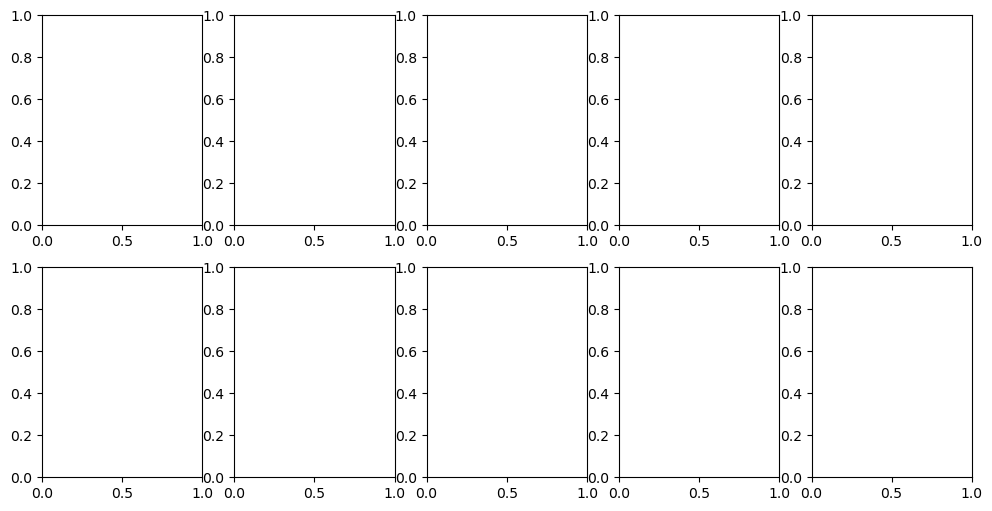

In [10]:
import copy
import matplotlib.pyplot as plt
import random
import sys
from utils import create_masked_data

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        _, image, _ = dataset[idx]
        # print(image)
        image = create_masked_data(image, 65535)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
np.set_printoptions(threshold=sys.maxsize)
random.seed(42)
visualize_augmentations(train_dataset)

### Trying out the model

In [ ]:
model = get_model()
# criterion = torch.nn.MSELoss()
criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Save the trained model
torch.save(trained_model.state_dict(), os.path.join(output_dir, "unet_evc_model_1.pth"))

# Evaluate on test set
test_dataset = CTXCRISMDataset(test_ctx, test_crism, transform=get_val_augmentations(patch_size))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_model(trained_model, test_loader, criterion, device)

Epoch [1/360], Train Loss: 1.8564
Validation Loss: 10.0368
Epoch [2/360], Train Loss: 1.3912
Validation Loss: 6.8644
Epoch [3/360], Train Loss: 0.7044
Validation Loss: 5.5416
Epoch [4/360], Train Loss: 0.3956
Validation Loss: 5.9940
Epoch [5/360], Train Loss: 0.2263
Validation Loss: 6.0217
Epoch [6/360], Train Loss: 0.2601
Validation Loss: 5.4839
Epoch [7/360], Train Loss: 0.0981
Validation Loss: 4.7424
Epoch [8/360], Train Loss: 1.4891
Validation Loss: 4.9191
Epoch [9/360], Train Loss: 1.2305
Validation Loss: 3.6083
Epoch [10/360], Train Loss: 0.0547
Validation Loss: 2.3657
Epoch [11/360], Train Loss: 0.0503
Validation Loss: 1.8062
Epoch [12/360], Train Loss: 0.0316
Validation Loss: 1.3475
Epoch [13/360], Train Loss: 0.0379
Validation Loss: 1.0370
Epoch [14/360], Train Loss: 0.0679
Validation Loss: 1.0501
Epoch [15/360], Train Loss: 0.0397
Validation Loss: 0.8532
Epoch [16/360], Train Loss: 0.0194
Validation Loss: 0.7594
Epoch [17/360], Train Loss: 0.0269
Validation Loss: 0.6519
Epoch

### Checking shapes

In [2]:
for ctx_data, crism_data, mask in train_loader:
    print("CTX Min:", ctx_data.min(), "CTX Max:", ctx_data.max(), "CTX NaNs:", torch.isnan(ctx_data).sum())
    print("CRISM Min:", crism_data.min(), "CRISM Max:", crism_data.max(), "CRISM NaNs:", torch.isnan(crism_data).sum())
    print("Mask sum", mask.sum())
    print(ctx_data.shape, crism_data.shape, mask.shape)

torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([3, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([3, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([3, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([3, 256, 256])
CTX Min: tensor(0.) CTX Max: tensor(0.1344) CTX NaNs: tensor(0)
CRISM Min: tensor(0.0517) CRISM Max: tensor(65535.) CRISM NaNs: tensor(0)
Mask sum tensor(91775)
torch.Size([4, 1, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


#### Ignore this cell

In [4]:
ctx = "./ctx/cropped/FRT000047A3_07_IFEVCJ_MTR3_P04_002743_1987_XI_18N282W.cub"
crism = "normalized_evc/FRT000047A3_07_IFEVCJ_MTR3.rp.global.local.img"

with rasterio.open(ctx) as ctx_ds, rasterio.open(crism) as crism_ds:
    ctx_data = ctx_ds.read().astype(np.float32)
    
    print(evaluate_model(model=model, ctx_image=ctx_data, patch_size=256, device=device))

    # crism_data = crism_ds.read().astype(np.float32)

    # mask = create_mask(crism_data)

# print(ctx_data.shape, crism_data.shape, mask.shape)
# print(mask)

NameError: name 'model' is not defined

### Pixel-wise training (irrelevant)

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from neural_network_2 import *
from utils import *

ctx_train_dir = "./ctx/cropped"
crism_train_dir = "./normalized_evc"
ctx_test_dir = "./ctx/cropped/test"
crism_test_dir = "./normalized_evc/test"
ctx_val_dir = "./ctx/cropped/val"
crism_val_dir = "./normalized_evc/val"
output_dir = "./results"

train_ctx, train_crism = get_files_from_dir(ctx_train_dir, ".cub"), get_files_from_dir(crism_train_dir, ".img")
test_ctx, test_crism = get_files_from_dir(ctx_test_dir, ".cub"), get_files_from_dir(crism_test_dir, ".img")
val_ctx, val_crism = get_files_from_dir(ctx_val_dir, ".cub"), get_files_from_dir(crism_val_dir, ".img")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = CTXCRISMValidPixelDataset(train_ctx, train_crism)
val_dataset = CTXCRISMValidPixelDataset(val_ctx, val_crism)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=4)

model = PixelwiseMLP(input_dim=1, output_dim=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trained_model = train_pixelwise_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, device=device)

os.makedirs(output_dir, exist_ok=True)
torch.save(trained_model.state_dict(), "output/pixelwise_model.pth")



Epoch [1/100], Train Loss: 0.0001
Validation Loss 0.0001
Epoch [2/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [3/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [4/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [5/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [6/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [7/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [8/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [9/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [10/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [11/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [12/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [13/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [14/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [15/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [16/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [17/100], Train Loss: 0.0001
Validation Loss 0.0000
Epoch [18/100], Train L

### Model evaluation
Simple version of evaluation without overlapping striding window and Gaussian averaging

In [11]:
import torch
from neural_network import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()

model.load_state_dict(torch.load("./results/unet_evc_model_1.pth", map_location=device))
model.to(device)
model.eval()

C:\Users\USER\AppData\Local\Temp\ipykernel_22172\1395635816.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./results/unet_evc_model_1.

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [12]:
import rasterio
import numpy as np

def load_ctx_image(ctx_path):
    with rasterio.open(ctx_path) as ctx_ds:
        ctx_data = ctx_ds.read(1).astype(np.float32)  # Assuming a single-channel CTX image
    return ctx_data

ctx_path = "./ctx/cropped/test/FRT0001ECBA_07_IFEVCJ_MTR3_G13_023102_1986_XN_18N282W.cub"

ctx_image = load_ctx_image(ctx_path)


In [13]:
patch_size = 256
predicted_crism = evaluate_model(model, ctx_image, patch_size, device)

In [14]:
print(predicted_crism.min(), predicted_crism.max())

-0.14650206 0.3811394


In [15]:
def save_envi_image(output_path, data, reference_ctx_path):
    with rasterio.open(reference_ctx_path) as ref_ds:
        meta = ref_ds.meta.copy()

    meta.update({
        "driver": "ENVI",
        "count": data.shape[0],  # Number of channels
        "dtype": rasterio.float32,
    })

    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(data)

save_envi_image("test.img", predicted_crism, ctx_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14650206..0.3811394].


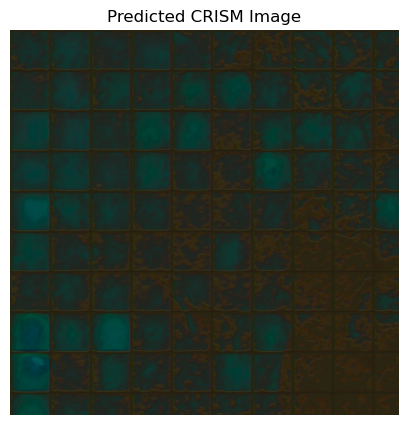

In [16]:
import matplotlib.pyplot as plt

def show_prediction(predicted_crism):
    plt.figure(figsize=(10, 5))
    plt.imshow(np.moveaxis(predicted_crism, 0, -1))  # Move channels to last axis
    plt.title("Predicted CRISM Image")
    plt.axis("off")
    plt.show()

show_prediction(predicted_crism)
